## Import

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [60]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

## Env Setting

In [37]:
seed = 2000
# CREATING THE ENVIRONMENT
env_name = "CartPole-v1"
env = gym.make(env_name)
env.seed(seed)

[2000]

## ActorCriticNetwork

In [56]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # actor params
        self.actor_fc1 = nn.Linear(input_size, hidden_size)
        self.actor_fc2 = nn.Linear(hidden_size, output_size)

        # critic params
        self.critic_fc1 = nn.Linear(input_size, hidden_size)
        self.critic_fc2 = nn.Linear(hidden_size, hidden_size)
        self.critic_fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        actor_x = F.tanh(self.actor_fc1(x))
        policy = F.softmax(self.actor_fc2(actor_x), dim=-1)

        critic_x = F.tanh(self.critic_fc1(x))
        critic_x = F.tanh(self.critic_fc2(critic_x))
        value = self.critic_fc3(critic_x)

        return policy, value

## Agent

In [57]:
class Agent:
    def __init__(self, env, hyper_parameters:dict):
        self.env = env
        self.action_size = env.action_space.n
        self.state_shape = env.observation_space.shape[0]

        # hyper params
        self.gamma = hyper_parameters['gamma']
        self.lr = hyper_parameters['lr']

        # actor critic network
        self.a2c = ActorCriticNetwork(self.state_shape, 32, self.action_size)
        self.optimizer = optim.Adam(self.a2c.parameters(), lr=self.lr)

    def get_action(self, state:torch.Tensor):
        policy, _ = self.a2c(state)
        policy = policy.detach().numpy()
        action = np.random.choice(self.action_size, p=policy)
        return action

    def train(self, state:torch.Tensor, action:int, reward:int, next_state:torch.Tensor, done:bool):

        self.a2c.train()

        policy, value = self.a2c(state)
        _, next_value = self.a2c(next_state)

        target = reward + (1 - done) * self.gamma * next_value
        advantage = target - value

        # actor(policy) nn
        action_prob = policy[action]
        log_prob = torch.log(action_prob + 1e-8)
        actor_loss = -log_prob * advantage.detach() # policy update 과정이니, value 신경망이 개입하면 안된다.

        # critic nn
        critic_loss = advantage.pow(2) # 제곱한다는 의미

        # total loss
        total_loss = actor_loss + critic_loss

        # back propagation
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        return total_loss.item()


## Hyper Params

In [62]:
HYPER_PARAMETERS = {
    'gamma' : 0.99,
    'lr' : 1e-3
}

N_EPISODES = 1000
MAX_STEPS = 500
PRINT_INTERVAL = 20

## main

In [64]:
# setting
env = gym.make(env_name)
agent = Agent(env, HYPER_PARAMETERS)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [65]:
reward_history = []
loss_history = []

for e in range(N_EPISODES):
    done = False
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    total_reward = 0
    total_n_steps = 0
    loss_list = []

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        total_reward += reward
        loss = agent.train(state, action, reward, next_state, done)
        if not np.isnan(loss):
            loss_list.append(loss)

        total_n_steps += 1
        if total_n_steps >= MAX_STEPS:
            break

        state = next_state

    reward_history.append(total_reward)
    loss_history.append(np.mean(loss_list))

    # PRINT_INTERVAL 마다 평균 출력
    if (e + 1) % PRINT_INTERVAL == 0:
        avg_reward = np.mean(reward_history[-PRINT_INTERVAL:])
        avg_loss = np.mean(loss_history[-PRINT_INTERVAL:])
        print(f"[Episode {e+1}] Average Reward: {avg_reward:.2f}, Average Loss: {avg_loss:.4f}")

[Episode 20] Average Reward: 20.70, Average Loss: 1.5551
[Episode 40] Average Reward: 24.45, Average Loss: 1.4687
[Episode 60] Average Reward: 37.30, Average Loss: 1.5445
[Episode 80] Average Reward: 39.90, Average Loss: 1.5376
[Episode 100] Average Reward: 50.60, Average Loss: 1.4881
[Episode 120] Average Reward: 54.05, Average Loss: 1.3841
[Episode 140] Average Reward: 49.15, Average Loss: 1.1756
[Episode 160] Average Reward: 91.90, Average Loss: 1.0753
[Episode 180] Average Reward: 92.80, Average Loss: 0.8411
[Episode 200] Average Reward: 189.15, Average Loss: 1.4788
[Episode 220] Average Reward: 187.55, Average Loss: 1.1181
[Episode 240] Average Reward: 316.90, Average Loss: 1.7803
[Episode 260] Average Reward: 82.10, Average Loss: 1.5099
[Episode 280] Average Reward: 311.95, Average Loss: 1.5101
[Episode 300] Average Reward: 478.00, Average Loss: 1.4396
[Episode 320] Average Reward: 217.55, Average Loss: 1.4520
[Episode 340] Average Reward: 500.00, Average Loss: 1.4184
[Episode 36

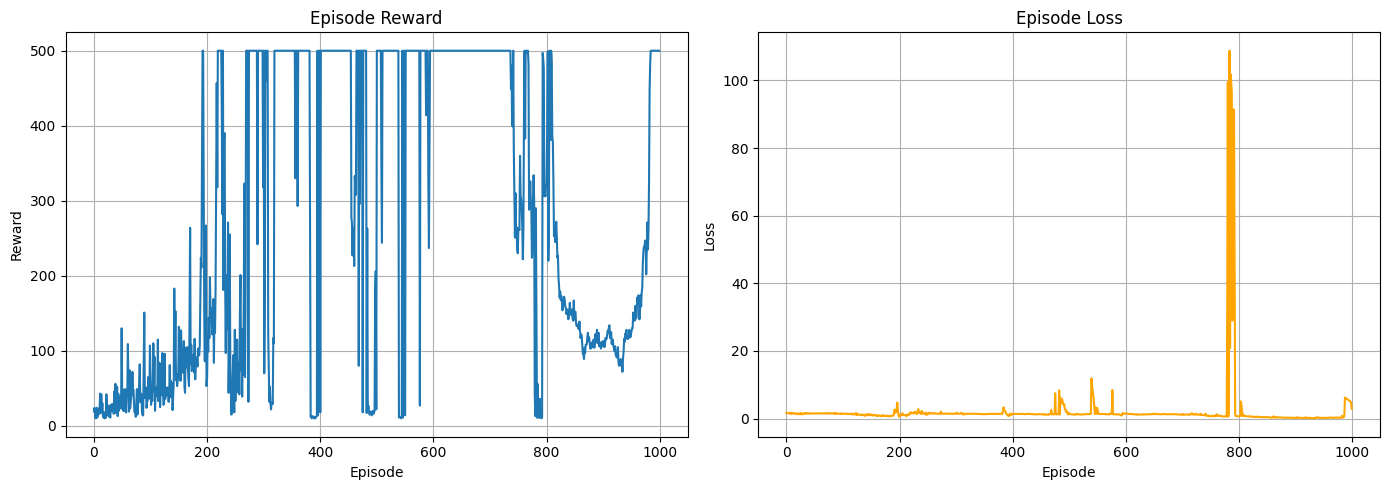

In [66]:
# 시각화
plt.figure(figsize=(14, 5))

# Reward
plt.subplot(1, 2, 1)
plt.plot(reward_history, label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Reward')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Loss', color='orange')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Episode Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [71]:
torch.save(agent.a2c.state_dict(), 'a2c_cartpole.pth')